# TensorFlow Content-based Filtering with Embedding (Paragraph2vec)


http://cs.stanford.edu/~quocle/paragraph_vector.pdf

http://research.google.com/pubs/pub44894.html

https://www.tensorflow.org/tutorials/word2vec

## Movielens Dataset

[Notebook](MovieLens Small Dataset.ipynb)

### TensorFlow Paragraph2vec

In [1]:
import csv

items = dict() # dict of id -> text (words)
ignored = list()

with open('movielens/ml-latest-small/plots.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for movie_id, movie_plot in reader:
        if movie_plot == 'N/A':
            ignored.append(movie_id)
            continue
        items[movie_id] = movie_plot

print('Number of movies: {:,d}'.format(len(items)))
print('Number of N/A: {:,d}'.format(len(ignored)))

Number of movies: 9,108
Number of N/A: 17


In [2]:
from scipy import stats

sizes = list(len(movie_plot) for movie_plot in items.values())
stats.describe(sizes)

DescribeResult(nobs=9108, minmax=(25, 5585), mean=512.50614844093104, variance=132895.07441041915, skewness=2.165082161250325, kurtosis=9.675609846339958)

In [3]:
names = dict() # dict of id -> name

with open('movielens/ml-latest-small/movies.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for movie_id, movie_name, _ in reader:
        names[movie_id] = movie_name

len(names)

9125

In [4]:
import nltk
import os

nltk_data_dir = os.path.abspath('./nltk_data')
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.data.path.insert(0, nltk_data_dir)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/cavani/Workspace/tensorflow-
[nltk_data]     jupyter/workspace/Recommendation/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
for movie_id, movie_plot in list(items.items())[:5]:
    print(names.get(movie_id, movie_id))
    print()
    print(movie_plot)
    print()
    print(nltk.word_tokenize(movie_plot.lower()))
    print()

Taking of Pelham One Two Three, The (1974)

Four seemingly-unrelated men board subway train Pelham 1:23 at successive stations. Mr. Blue, Mr. Green, Mr. Grey and Mr. Brown are heavily armed and overpower the motorman and novice conductor to take control of the train. Between stations they separate the front car from the remainder of the train, setting passengers in the back cars and the motorman free. The four demand $1 million ransom within exactly one hour for the remaining eighteen hostages, including the conductor. If their demands are not met in time or their directions are not followed precisely, they will begin to shoot hostages dead, one every minute the money is late. Wisecracking Lt. Zach Garber of the transit police ends up being the primary communicator between the hijackers and the authorities, which includes transit operations, his own police force, the NYPD, and the unpopular and currently flu ridden mayor who will make the ultimate decision of whether to pay the ransom.

In [6]:
import collections

VOCABULARY_SIZE = 50000

class DocumentCorpus:
    
    def __init__(self, documents, titles, document_ids, vocabulary_size=VOCABULARY_SIZE):
        self.documents = documents = dict((doc_id, documents[doc_id]) for doc_id in document_ids)
        self.titles = documents = dict((doc_id, titles[doc_id]) for doc_id in document_ids)
        
        documents_words = dict((doc_id, nltk.word_tokenize(doc_raw.lower()))
                               for doc_id, doc_raw in self.documents.items())
        
        words_flat = (word for doc_words in documents_words.values() for word in doc_words)
        words = collections.Counter(words_flat).most_common(vocabulary_size - 1)
        
        word_to_idx = dict((word, i+1) for i, (word, _) in enumerate(words))
        word_to_idx['UNK'] = 0
        word_from_idx = dict((idx, word) for word, idx in word_to_idx.items())
        
        self._word_to_idx = word_to_idx
        self._word_from_idx = word_from_idx
        
        document_vectors = list()
        document_to_idx = dict()
        document_from_idx = dict()
        
        unk_idx = word_to_idx['UNK']
        unk_count = 0
        
        for i, (doc_id, doc_words) in enumerate(documents_words.items()):
            doc_vec = list(word_to_idx.get(word, unk_idx) for word in doc_words)
            document_vectors.append(doc_vec)
            document_to_idx[doc_id] = i
            document_from_idx[i] = doc_id
            
            unk_count += doc_vec.count(unk_idx)
        
        words.insert(0, ('UNK', unk_count))
        
        self.document_vectors = document_vectors
        self.document_to_idx = document_to_idx
        self.document_from_idx = document_from_idx
        
        self.words = sorted(words, key=lambda w: w[1], reverse=True)
    
    @property
    def vocabulary_size(self):
        return len(self.words)
    
    @property
    def documents_size(self):
        return len(self.document_vectors)
    
    def most_common_words(self, n=5):
        return self.words[:n]
    
    def word_to_idx(self, word):
        return self._word_to_idx.get(word, 0) # 0 = UNK
    
    def word_from_idx(self, i):
        return self._word_from_idx[i]

    def raw_from_id(self, doc_id):
        return self.documents[doc_id]
    
    def raw_from_idx(self, i):
        doc_id = self.document_from_idx[i]
        return self.documents[doc_id]
    
    def title_from_id(self, doc_id):
        return self.titles[doc_id]
    
    def title_from_idx(self, i):
        doc_id = self.document_from_idx[i]
        return self.titles[doc_id]
    
    def vector_form_id(self, doc_id):
        i = self.document_to_idx[doc_id]
        return self.document_vectors[i]
    
    def vector_form_id_words(self, doc_id):
        doc_vec = self.vector_form_id(doc_id)
        return list(self.word_from_idx(w_i) for w_i in doc_vec)

train_ids = list(items.keys()) # list of id's
train_corpus = DocumentCorpus(items, names, train_ids)

print('Vocabulary size:\n')
print(train_corpus.vocabulary_size)
print('\nDocuments size:\n')
print(train_corpus.documents_size)
print('\nMost common words (+UNK):\n')
print(train_corpus.most_common_words())
print('\nDocument example: id={}\n'.format(train_ids[0]))
print(train_corpus.title_from_id(train_ids[0]), '\n')
print(train_corpus.raw_from_id(train_ids[0]), '\n')
print(train_corpus.vector_form_id(train_ids[0]), '\n')
print(train_corpus.vector_form_id_words(train_ids[0]))

Vocabulary size:

42086

Documents size:

9108

Most common words (+UNK):

[(',', 47938), ('the', 45433), ('.', 35269), ('a', 27780), ('to', 26522)]

Document example: id=3384

Taking of Pelham One Two Three, The (1974) 

Four seemingly-unrelated men board subway train Pelham 1:23 at successive stations. Mr. Blue, Mr. Green, Mr. Grey and Mr. Brown are heavily armed and overpower the motorman and novice conductor to take control of the train. Between stations they separate the front car from the remainder of the train, setting passengers in the back cars and the motorman free. The four demand $1 million ransom within exactly one hour for the remaining eighteen hostages, including the conductor. If their demands are not met in time or their directions are not followed precisely, they will begin to shoot hostages dead, one every minute the money is late. Wisecracking Lt. Zach Garber of the transit police ends up being the primary communicator between the hijackers and the authorities, whi

In [7]:
import numpy as np

class DocumentBatchGenerator:
    
    def __init__(self, document_vectors, batch_size, num_skips, skip_window):
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window

        self.num_epoch = 0
        self.document_vectors = document_vectors
        self.document_index = 0
        self.word_index = 0
        
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        
        self.window_size = 2 * skip_window + 1 # [ skip_window target skip_window ]

        self.window = collections.deque(maxlen=self.window_size)
        self.window_init()
        
    def window_init(self):
        for _ in range(self.window_size):
            self.window_next_word()
    
    def window_next_word(self):
        words = self.document_vectors[self.document_index]
        self.window.append(words[self.word_index % len(words)])
        self.word_index += 1
        
    def window_forward(self):
        words = self.document_vectors[self.document_index]
        if self.word_index >= len(words):
            next_document = self.document_index + 1
            if next_document == len(self.document_vectors):
                self.document_index = 0
                self.num_epoch += 1
            else:
                self.document_index = next_document
            self.word_index = 0
            self.window_init()
        else:
            self.window_next_word()
    
    def read(self):
        docs = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        batch = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(self.batch_size, 1), dtype=np.int32)
        
        for i in range(self.batch_size // self.num_skips):
            center = self.skip_window
            target = center
            targets_to_avoid = [ center ]
            for j in range(self.num_skips):
                while target in targets_to_avoid:
                    target = np.random.randint(0, self.window_size)
                targets_to_avoid.append(target)
                docs[i * self.num_skips + j] = self.document_index
                batch[i * self.num_skips + j] = self.window[center]
                labels[i * self.num_skips + j, 0] = self.window[target]
            self.window_forward()

        return docs, batch, labels

data_reader = DocumentBatchGenerator(train_corpus.document_vectors, batch_size=10, num_skips=2, skip_window=1)

def print_batch():
    docs, batch, labels = data_reader.read()
    for i in range(len(batch)):
        print('{}: ({}, {}) -> ({}, {})'.format(docs[i],
                                          batch[i],
                                          train_corpus.word_from_idx(batch[i]),
                                          labels[i, 0],
                                          train_corpus.word_from_idx(labels[i, 0])))

print('1st Batch:\n')
print_batch()

print('\n2nd Batch:\n')
print_batch()

print('\n3rd Batch:\n')
print_batch()

1st Batch:

0: (8, in) -> (691, france)
0: (8, in) -> (175, set)
0: (691, france) -> (8, in)
0: (691, france) -> (1, ,)
0: (1, ,) -> (4910, georges)
0: (1, ,) -> (691, france)
0: (4910, georges) -> (1, ,)
0: (4910, georges) -> (9, is)
0: (9, is) -> (4, a)
0: (9, is) -> (4910, georges)

2nd Batch:

0: (4, a) -> (9, is)
0: (4, a) -> (622, tv)
0: (622, tv) -> (4, a)
0: (622, tv) -> (4377, literary)
0: (4377, literary) -> (622, tv)
0: (4377, literary) -> (15640, reviewer)
0: (15640, reviewer) -> (4377, literary)
0: (15640, reviewer) -> (6, and)
0: (6, and) -> (107, lives)
0: (6, and) -> (15640, reviewer)

3rd Batch:

0: (107, lives) -> (8, in)
0: (107, lives) -> (6, and)
0: (8, in) -> (107, lives)
0: (8, in) -> (4, a)
0: (4, a) -> (203, small)
0: (4, a) -> (8, in)
0: (203, small) -> (4, a)
0: (203, small) -> (465, yet)
0: (465, yet) -> (929, modern)
0: (465, yet) -> (203, small)


In [8]:
import tensorflow as tf
import os
import shutil

class Paragraph2vecModel:
    
    #documents_size
    #vocabulary_size
    #embedding_size
    #num_sampled
    #learning_rate
    
    #input_docs
    #input_data
    #input_labels
    #loss
    #train
    #docs_embeddings
    #words_embeddings
    
    def __init__(self,
                 documents_size,
                 vocabulary_size,
                 embedding_size,
                 num_sampled,
                 learning_rate):
        self.documents_size = documents_size
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.learning_rate = learning_rate
        
        self.build_graph()
    
    def build_graph(self):
        self.input_docs = tf.placeholder(tf.int32, shape=[None])
        self.input_data = tf.placeholder(tf.int32, shape=[None])
        self.input_labels = tf.placeholder(tf.int32, shape=[None, 1])
        
        init_width = 0.5 / self.embedding_size
        
        docs_embeddings = tf.Variable(
            tf.random_uniform(
                [self.documents_size, self.embedding_size],
                -init_width,
                init_width),
            name='docs_embeddings')
        docs_lookup = tf.nn.embedding_lookup(docs_embeddings, self.input_docs)

        words_embeddings = tf.Variable(
            tf.random_uniform(
                [self.vocabulary_size, self.embedding_size],
                -init_width,
                init_width),
            name='words_embeddings')
        words_lookup = tf.nn.embedding_lookup(words_embeddings, self.input_data)

        embed = tf.concat([docs_lookup, words_lookup], 1)
        
        nce_weights = tf.Variable(
            tf.truncated_normal(
                [self.vocabulary_size, 2 * self.embedding_size],
                stddev=1.0 / np.sqrt(2 * self.embedding_size)))
        nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))
    
        self.loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=self.input_labels,
                inputs=embed,
                num_sampled=self.num_sampled,
                num_classes=self.vocabulary_size))

        self._lr = tf.Variable(self.learning_rate, trainable=False)
        self._new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")
        self._lr_update = tf.assign(self._lr, self._new_lr)
        
        global_step = tf.Variable(0, name='global_step', trainable=False)

        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self._lr)
        #self.train = optimizer.minimize(self.loss, global_step=global_step, gate_gradients=optimizer.GATE_NONE)
        self.train = optimizer.minimize(self.loss, global_step=global_step)

        docs_norm = tf.sqrt(tf.reduce_sum(tf.square(docs_embeddings), 1, keep_dims=True))
        self.docs_embeddings = docs_embeddings / docs_norm
        
        words_norm = tf.sqrt(tf.reduce_sum(tf.square(words_embeddings), 1, keep_dims=True))
        self.words_embeddings = words_embeddings / words_norm

    def lr(self, session):
        return session.run(self._lr)
    
    def assign_lr(self, session, lr_value):
        session.run(self._lr_update, feed_dict={self._new_lr: lr_value})


class NearestWordsQuery:
    
    def __init__(self, embeddings, mapping, words, k=8):
        input_words = tf.constant(words, dtype=tf.int32)
        words_embeddings = tf.nn.embedding_lookup(embeddings, input_words)
        similarity = tf.matmul(words_embeddings, embeddings, transpose_b=True)
        self.nearest = tf.nn.top_k(similarity, k+1)
        
        self.mapping = mapping
        self.words = words

    def word_from_idx(self, i):
        return self.mapping.word_from_idx(i)
    
    def run(self, session):
        nearest_val, nearest_idx = session.run(self.nearest)
        for i, word_idx in enumerate(self.words):
            word = self.word_from_idx(word_idx)
            nearest_pairs = zip(nearest_idx[i], nearest_val[i])
            next(nearest_pairs)
            nearest_words = ', '.join('{} ({:,.3f})'.format(self.word_from_idx(w_i), w_n)
                                      for w_i, w_n in nearest_pairs)
            print('Nearest to {}: {}'.format(word, nearest_words))


class NearestDocsQuery:
    
    def __init__(self, embeddings, mapping, docs, k=3):
        input_docs = tf.constant(docs, dtype=tf.int32)
        docs_embeddings = tf.nn.embedding_lookup(embeddings, input_docs)
        similarity = tf.matmul(docs_embeddings, embeddings, transpose_b=True)
        self.nearest = tf.nn.top_k(similarity, k+1)
        
        self.mapping = mapping
        self.docs = docs

    def doc_from_idx(self, i):
        return self.mapping.title_from_idx(i), self.mapping.raw_from_idx(i)
    
    def run(self, session):
        nearest_val, nearest_idx = session.run(self.nearest)
        for i, doc_idx in enumerate(self.docs):
            doc_title, doc_text = self.doc_from_idx(doc_idx)
            print('{}\n\n{}\n'.format(doc_title, doc_text))
            for n, (near_idx, near_sim) in enumerate(zip(nearest_idx[i], nearest_val[i])):
                if n == 0:
                    continue
                near_title, near_text = self.doc_from_idx(near_idx)
                print('[ {}, {:,.3f} ] {}\n\n{}\n'.format(n, near_sim, near_title, near_text))
            print('---\n')


class Paragraph2vecTrainer:
    
    #corpus
    #batch_size
    #num_skips
    #skip_window
    #embedding_size
    #num_sampled

    def __init__(self,
                 corpus,
                 batch_size,
                 num_skips,
                 skip_window,
                 embedding_size,
                 num_sampled,
                 learning_rate,
                 logdir='log/paragraph2vec'):
        self.corpus = corpus
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.learning_rate = learning_rate
        self.logdir = logdir
    
    def remove_log(self):
        if os.path.isdir(self.logdir):
            shutil.rmtree(self.logdir)
    
    def train(self, num_epochs=1, delay_lr_decay=0, reset_log=True):
        if reset_log:
            self.remove_log()
        
        data_reader = self.data_reader()
        
        with tf.Graph().as_default():
            model = self.build_model()
            
            doc_query = self.nearest_docs(model)
            word_query = self.nearest_words(model)
            
            sv = tf.train.Supervisor(logdir=self.logdir)
            with sv.managed_session() as session:
                train_ops = [model.train, model.loss]
                average_loss = 0
            
                step = 0
                last_epoch = data_reader.num_epoch
                while data_reader.num_epoch < num_epochs:
                    batch_docs, batch_data, batch_labels = data_reader.read()
                    feed_dict = {
                        model.input_docs: batch_docs,
                        model.input_data: batch_data,
                        model.input_labels: batch_labels,
                    }
                
                    _, loss_val = session.run(train_ops, feed_dict=feed_dict)
                    average_loss += loss_val

                    if step % 5000 == 0:
                        if step > 0:
                            average_loss /= 5000
                        print('Average loss at step {:,d}: {:,.3f}'.format(step, average_loss))
                        average_loss = 0
                                
                    step += 1
                
                    if data_reader.num_epoch != last_epoch:
                        last_epoch = data_reader.num_epoch

                        lr = model.lr(session)
                        if last_epoch >= delay_lr_decay:
                            model.assign_lr(session, max(0.00001, lr / 2))
                    
                        print()
                        print('Epoch {} (lr={:,.5f})'.format(last_epoch, lr))
                        print()
                        doc_query.run(session)
                        word_query.run(session)
                        print()

                print('Total steps: {:,d}'.format(step))
            
                docs_embeddings = session.run(model.docs_embeddings)
        
        return docs_embeddings
    
    def data_reader(self):
        return DocumentBatchGenerator(self.corpus.document_vectors,
                                      self.batch_size,
                                      self.num_skips,
                                      self.skip_window)

    def build_model(self):
        return Paragraph2vecModel(self.corpus.documents_size,
                                  self.corpus.vocabulary_size,
                                  self.embedding_size,
                                  self.num_sampled,
                                  self.learning_rate)
    
    def nearest_words(self, model):
        words = self.sample_words()
        return NearestWordsQuery(model.words_embeddings, self.corpus, words)
        
    def sample_words(self, sample_size=3):
        return np.random.choice(self.corpus.vocabulary_size - 1,
                                sample_size,
                                replace=False)

    def nearest_docs(self, model):
        docs = self.sample_docs()
        return NearestDocsQuery(model.docs_embeddings, self.corpus, docs)
        
    def sample_docs(self, sample_size=2):
        return np.random.choice(self.corpus.documents_size - 1,
                                sample_size,
                                replace=False)


In [9]:
%%time

trainer = Paragraph2vecTrainer(
    train_corpus,
    batch_size = 16,
    skip_window = 2,       # How many words to consider left and right.
    num_skips = 2,         # How many times to reuse an input to generate a label.
    embedding_size = 200,  # Dimension of the embedding vector.
    num_sampled = 100,     # Number of negative examples to sample.
    learning_rate = 0.2)   # Initial learning rate.

docs_embeddings = trainer.train(num_epochs=25, delay_lr_decay=20)
# docs_embeddings = trainer.train(num_epochs=1)

INFO:tensorflow:global_step/sec: 0
Average loss at step 0: 377.045
Average loss at step 5,000: 80.914
Average loss at step 10,000: 27.742
Average loss at step 15,000: 20.028
Average loss at step 20,000: 17.508
Average loss at step 25,000: 15.748
Average loss at step 30,000: 14.669
Average loss at step 35,000: 13.782
Average loss at step 40,000: 12.880
Average loss at step 45,000: 12.387
Average loss at step 50,000: 12.070
Average loss at step 55,000: 11.310
Average loss at step 60,000: 10.972
Average loss at step 65,000: 10.805
Average loss at step 70,000: 10.409
Average loss at step 75,000: 10.089
INFO:tensorflow:global_step/sec: 645.391
Average loss at step 80,000: 10.170
Average loss at step 85,000: 9.597
Average loss at step 90,000: 9.688
Average loss at step 95,000: 9.367
Average loss at step 100,000: 9.122
Average loss at step 105,000: 8.976

Epoch 1 (lr=0.20000)

Make Mine Music (1946)

Segments: "A Rustic Ballad," a story of feuding hillbillys; "A Tone Poem," a mood piece set o

Nearest to freed: baptized (0.873), seen (0.867), considered (0.861), parted (0.856), deemed (0.853), self-professed (0.852), meant (0.852), reassigned (0.850)
Nearest to awarded: invade (0.990), bear (0.988), inspires (0.988), 1863. (0.988), purchase (0.988), awkwardly (0.988), manned (0.988), re-open (0.988)
Nearest to industry: amid (0.988), korean (0.987), dipper (0.987), ocean (0.987), explores (0.987), pows (0.986), goddess (0.986), groom (0.986)

Average loss at step 220,000: 5.412
Average loss at step 225,000: 7.091
Average loss at step 230,000: 6.523
Average loss at step 235,000: 6.009
Average loss at step 240,000: 5.792
Average loss at step 245,000: 5.697
Average loss at step 250,000: 5.581
Average loss at step 255,000: 5.538
INFO:tensorflow:global_step/sec: 436.083
Average loss at step 260,000: 5.464
Average loss at step 265,000: 5.403
Average loss at step 270,000: 5.397
Average loss at step 275,000: 5.346
Average loss at step 280,000: 5.342
Average loss at step 285,000: 5.3

Nearest to freed: considered (0.823), baptized (0.809), tangina (0.803), benefiting (0.796), kept (0.792), modell (0.790), announced (0.790), meant (0.790)
Nearest to awarded: offered (0.953), length (0.952), hit-man (0.952), awkwardly (0.952), indo-canadian (0.950), uninhabitable (0.949), jeopardized (0.949), 29-year-old (0.949)
Nearest to industry: rooftop (0.956), curtain (0.953), emotive (0.953), amid (0.952), kraken (0.952), wotton (0.951), seaboard (0.950), wheaton (0.950)

Average loss at step 440,000: 5.031
Average loss at step 445,000: 5.644
Average loss at step 450,000: 5.536
Average loss at step 455,000: 5.287
Average loss at step 460,000: 5.214
INFO:tensorflow:global_step/sec: 424.598
Average loss at step 465,000: 5.159
Average loss at step 470,000: 5.095
Average loss at step 475,000: 5.064
Average loss at step 480,000: 5.042
Average loss at step 485,000: 4.991
Average loss at step 490,000: 4.992
Average loss at step 495,000: 4.961
Average loss at step 500,000: 4.979
Averag

Nearest to freed: benefiting (0.834), retrained (0.815), ousted (0.814), expelled (0.792), extracted (0.778), evicted (0.772), shielded (0.760), colonized (0.755)
Nearest to awarded: ophthalmologist (0.920), 29-year-old (0.918), homage (0.917), spoof (0.916), headhunter (0.915), upper-crust (0.914), looming (0.914), crate (0.912)
Nearest to industry: steering (0.897), curtain (0.896), concentrates (0.893), kraken (0.893), mutative (0.893), rooftop (0.892), dipper (0.892), economy (0.892)

Average loss at step 660,000: 4.695
Average loss at step 665,000: 4.954
Average loss at step 670,000: 4.946
Average loss at step 675,000: 4.833
Average loss at step 680,000: 4.784
Average loss at step 685,000: 4.754
Average loss at step 690,000: 4.713
Average loss at step 695,000: 4.702
Average loss at step 700,000: 4.679
Average loss at step 705,000: 4.642
Average loss at step 710,000: 4.649
Average loss at step 715,000: 4.633
Average loss at step 720,000: 4.632
Average loss at step 725,000: 4.619
Av

Average loss at step 880,000: 4.394
Average loss at step 885,000: 4.502
Average loss at step 890,000: 4.523
Average loss at step 895,000: 4.449
Average loss at step 900,000: 4.454
Average loss at step 905,000: 4.412
Average loss at step 910,000: 4.382
Average loss at step 915,000: 4.367
Average loss at step 920,000: 4.367
Average loss at step 925,000: 4.345
Average loss at step 930,000: 4.334
Average loss at step 935,000: 4.332
Average loss at step 940,000: 4.346
Average loss at step 945,000: 4.316
Average loss at step 950,000: 4.329
Average loss at step 955,000: 4.302
Average loss at step 960,000: 4.324
Average loss at step 965,000: 4.300
Average loss at step 970,000: 4.293
Average loss at step 975,000: 4.306
Average loss at step 980,000: 4.289
Average loss at step 985,000: 4.290

Epoch 9 (lr=0.20000)

Make Mine Music (1946)

Segments: "A Rustic Ballad," a story of feuding hillbillys; "A Tone Poem," a mood piece set on a blue bayou; "A Jazz Interlude," a bobby-soxer goes jitterbugging

Average loss at step 1,170,000: 4.090
Average loss at step 1,175,000: 4.068
Average loss at step 1,180,000: 4.084
Average loss at step 1,185,000: 4.055
Average loss at step 1,190,000: 4.072
Average loss at step 1,195,000: 4.076
Average loss at step 1,200,000: 4.071
Average loss at step 1,205,000: 4.061

Epoch 11 (lr=0.20000)

Make Mine Music (1946)

Segments: "A Rustic Ballad," a story of feuding hillbillys; "A Tone Poem," a mood piece set on a blue bayou; "A Jazz Interlude," a bobby-soxer goes jitterbugging with her date at the malt shop; "A Ballad in Blue," dark room, rain and somber landscapes illustrate the loss of a lover; "A Musical Recitation," the story of Casey at the Bat; "Ballade Ballet," ballet dancers perform in silhouette; "A Fairy Tale with Music," Peter and the Wolf; "After You've Gone," four musical instruments chase through a surreal landscape; "A Love Story," about the romance between a fedora and a bonnet; "Opera Pathetique," the story of Willie, the Whale Who Wante

Nearest to freed: ousted (0.757), retrained (0.747), benefiting (0.719), extracted (0.718), expelled (0.703), banished (0.690), evicted (0.681), selections (0.681)
Nearest to awarded: bialystock (0.824), hanged (0.823), ensnared (0.820), advertisement (0.816), ibáñez (0.809), globe-trotting (0.809), 29-year-old (0.803), mitchell- (0.803)
Nearest to industry: studio (0.655), dalai (0.649), hms (0.645), longest (0.644), recreates (0.630), meanies (0.627), '84 (0.625), guillotine (0.622)

Average loss at step 1,430,000: 3.835
Average loss at step 1,435,000: 3.889
Average loss at step 1,440,000: 3.878
Average loss at step 1,445,000: 3.867
Average loss at step 1,450,000: 3.881
Average loss at step 1,455,000: 3.856
Average loss at step 1,460,000: 3.827
Average loss at step 1,465,000: 3.864
Average loss at step 1,470,000: 3.827
Average loss at step 1,475,000: 3.845
Average loss at step 1,480,000: 3.835
Average loss at step 1,485,000: 3.849
Average loss at step 1,490,000: 3.850
Average loss at

Average loss at step 1,685,000: 3.741
Average loss at step 1,690,000: 3.709
Average loss at step 1,695,000: 3.741
Average loss at step 1,700,000: 3.680
Average loss at step 1,705,000: 3.724
Average loss at step 1,710,000: 3.720
Average loss at step 1,715,000: 3.663
Average loss at step 1,720,000: 3.734
Average loss at step 1,725,000: 3.703
Average loss at step 1,730,000: 3.720
Average loss at step 1,735,000: 3.688
Average loss at step 1,740,000: 3.711
Average loss at step 1,745,000: 3.725
Average loss at step 1,750,000: 3.710
Average loss at step 1,755,000: 3.690

Epoch 16 (lr=0.20000)

Make Mine Music (1946)

Segments: "A Rustic Ballad," a story of feuding hillbillys; "A Tone Poem," a mood piece set on a blue bayou; "A Jazz Interlude," a bobby-soxer goes jitterbugging with her date at the malt shop; "A Ballad in Blue," dark room, rain and somber landscapes illustrate the loss of a lover; "A Musical Recitation," the story of Casey at the Bat; "Ballade Ballet," ballet dancers perform in

Nearest to freed: banished (0.667), benefiting (0.666), expelled (0.660), extracted (0.656), ousted (0.643), plucked (0.638), demolished (0.636), retrained (0.635)
Nearest to awarded: pioneer (0.735), contaminated (0.733), sacrificial (0.732), hanged (0.732), bialystock (0.730), parasite (0.725), sword-fishing (0.723), advertisement (0.722)
Nearest to industry: hms (0.526), guillotine (0.524), weaves (0.523), festival (0.517), '84 (0.513), studio (0.511), unveils (0.505), longest (0.504)

Average loss at step 1,980,000: 3.630
Average loss at step 1,985,000: 3.625
Average loss at step 1,990,000: 3.645
Average loss at step 1,995,000: 3.596
Average loss at step 2,000,000: 3.609
Average loss at step 2,005,000: 3.615
Average loss at step 2,010,000: 3.609
Average loss at step 2,015,000: 3.623
Average loss at step 2,020,000: 3.594
Average loss at step 2,025,000: 3.617
Average loss at step 2,030,000: 3.589
Average loss at step 2,035,000: 3.602
Average loss at step 2,040,000: 3.617
Average loss

Average loss at step 2,240,000: 3.290
Average loss at step 2,245,000: 3.276
Average loss at step 2,250,000: 3.270
Average loss at step 2,255,000: 3.285
Average loss at step 2,260,000: 3.303
Average loss at step 2,265,000: 3.236
Average loss at step 2,270,000: 3.297
Average loss at step 2,275,000: 3.302
Average loss at step 2,280,000: 3.286
Average loss at step 2,285,000: 3.257
Average loss at step 2,290,000: 3.277
Average loss at step 2,295,000: 3.287
Average loss at step 2,300,000: 3.263
Average loss at step 2,305,000: 3.245

Epoch 21 (lr=0.10000)

Make Mine Music (1946)

Segments: "A Rustic Ballad," a story of feuding hillbillys; "A Tone Poem," a mood piece set on a blue bayou; "A Jazz Interlude," a bobby-soxer goes jitterbugging with her date at the malt shop; "A Ballad in Blue," dark room, rain and somber landscapes illustrate the loss of a lover; "A Musical Recitation," the story of Casey at the Bat; "Ballade Ballet," ballet dancers perform in silhouette; "A Fairy Tale with Music,

Nearest to freed: benefiting (0.667), banished (0.667), extracted (0.643), expelled (0.641), plucked (0.636), ousted (0.616), bouncing (0.616), demolished (0.610)
Nearest to awarded: copywriter (0.710), parasite (0.707), advertisement (0.705), deep-sea (0.703), emotionless (0.702), hanged (0.701), ingenious (0.700), bio-nerve (0.700)
Nearest to industry: hms (0.512), guillotine (0.500), weaves (0.496), studio (0.495), longest (0.492), 3rd (0.491), '84 (0.491), bloodily (0.489)

Average loss at step 2,530,000: 3.001
Average loss at step 2,535,000: 3.022
Average loss at step 2,540,000: 3.001
Average loss at step 2,545,000: 3.007
Average loss at step 2,550,000: 3.006
Average loss at step 2,555,000: 3.006
Average loss at step 2,560,000: 3.012
Average loss at step 2,565,000: 2.987
Average loss at step 2,570,000: 3.000
Average loss at step 2,575,000: 2.975
Average loss at step 2,580,000: 2.981
Average loss at step 2,585,000: 2.994
Average loss at step 2,590,000: 2.998
Average loss at step 2,

In [10]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(docs_embeddings)
labels = list(train_corpus.document_from_idx[i] for i in range(docs_embeddings.shape[0]))

CPU times: user 2min 25s, sys: 30.1 s, total: 2min 55s
Wall time: 2min 53s


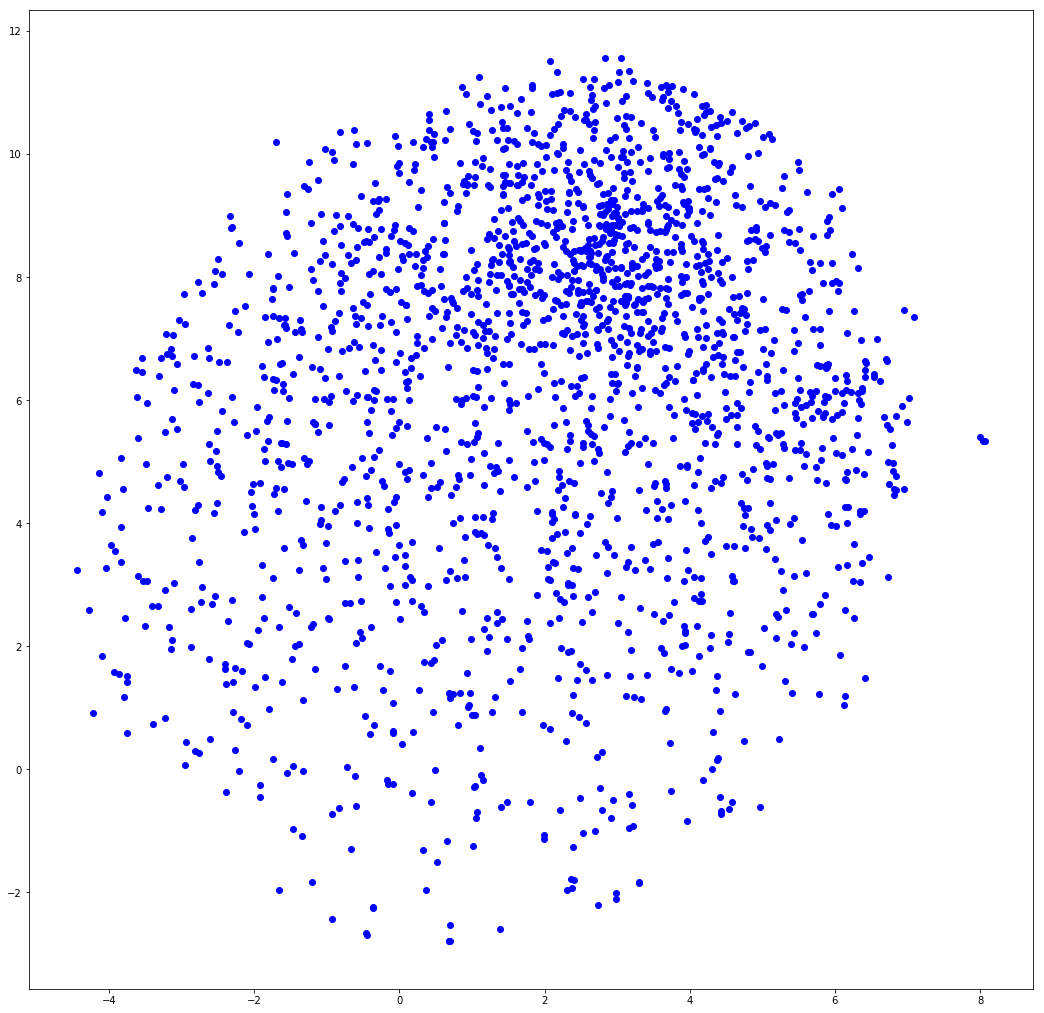

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

points = np.random.choice(len(labels), 2000, replace=False)

plt.figure(figsize=(18, 18))  #in inches
for i in points:
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y, color='b')
    #label = labels[i]
    #plt.annotate(
    #    label,
    #    xy=(x, y),
    #    xytext=(5, 2),
    #    textcoords='offset points',
    #    ha='right',
    #    va='bottom')

plt.show()

### Content-based User-Item: Avarage with Time Decay

In [12]:
import collections
import csv

MovieWatch = collections.namedtuple('MovieWatch', ['movie_id', 'timestamp'])

users = collections.defaultdict(list)
with open('movielens/ml-latest-small/ratings.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for user_id, item_id, _, timestamp in reader:
        users[user_id].append(MovieWatch(item_id, int(timestamp)))

len(users)

671

In [13]:
from scipy import stats

watch_counts = list(len(movies) for movies in users.values())
stats.describe(watch_counts)

DescribeResult(nobs=671, minmax=(20, 2391), mean=149.03725782414307, variance=53465.901594857307, skewness=4.544628118876827, kurtosis=28.187338511028905)

In [14]:
user_items = dict()
for user, movies in users.items():
    items = list()
    movies = sorted(movies, key=lambda m: int(m.timestamp))
    for movie_id, _ in movies:
        if movie_id not in train_corpus.document_to_idx:
            continue
        i = train_corpus.document_to_idx[movie_id]
        items.append(i)
    user_items[user] = items

stats.describe(list(len(items) for items in user_items.values()))

DescribeResult(nobs=671, minmax=(20, 2390), mean=149.01043219076007, variance=53439.171532798006, skewness=4.543824643860775, kurtosis=28.17625406587095)

In [15]:
class Recommender:
    
    def __init__(self, item_embeddings, user_items, mapping, decay):
        self.item_embeddings = item_embeddings
        n_items = item_embeddings.shape[0]
        
        self.user_items = user_items
        self.user_u = dict()
        self.user_t = collections.defaultdict(int)
        self.user_h = collections.defaultdict(lambda: np.zeros(n_items))
        
        self.mapping = mapping
        self.decay = decay
    
    def user_vec(self, user_id, t):
        items = self.user_items[user_id]
        
        if t >= len(items):
            return self.user_u[user_id], self.user_h[user_id]
        
        i = items[t]
        v = self.item_embeddings[i]
        if t == 0:
            u = v
        else:
            u = v + self.decay * self.user_u[user_id]
            u = u / np.linalg.norm(u)
        self.user_u[user_id] = u
        h = self.user_h[user_id]
        h[i] = 1
        
        return u, h
        
    def recommend(self, user_id, k=3):
        if user_id not in self.user_items:
            return None
        
        t = self.user_t[user_id]
        self.user_t[user_id] += 1
        
        u, h = self.user_vec(user_id, t)
        
        d = np.dot(self.item_embeddings, u)
        d = np.multiply(d, 1 - h)
        rank = d.argsort()[::-1][:k]
        
        return list(self.mapping.document_from_idx[i] for i in rank)

In [16]:
user_id, items = list(user_items.items())[0]

print('{} (movies = {:,d})'.format(user_id, len(items)))
print()

rec = Recommender(docs_embeddings, user_items, train_corpus, 0.8)

for k, last_item in enumerate(items):
    print(train_corpus.title_from_idx(last_item))
    rec_items = rec.recommend(user_id)
    if k < len(items) - 10:
        continue
    print()
    for i, item_id in enumerate(rec_items):
        print('[ {} ] {}'.format(i+1, train_corpus.title_from_id(item_id)))
    print()

410 (movies = 28)

Star Wars: Episode IV - A New Hope (1977)
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Shawshank Redemption, The (1994)
Matrix, The (1999)
Pulp Fiction (1994)
Forrest Gump (1994)
Jurassic Park (1993)
Braveheart (1995)
Toy Story (1995)
Schindler's List (1993)
Speed (1994)
Ace Ventura: Pet Detective (1994)
Mission: Impossible (1996)
Die Hard: With a Vengeance (1995)
True Lies (1994)
Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
Fargo (1996)
Groundhog Day (1993)
Dumb & Dumber (Dumb and Dumber) (1994)

[ 1 ] Welcome to the Jungle (2013)
[ 2 ] Miles Ahead (2016)
[ 3 ] Helvetica (2007)

Stargate (1994)

[ 1 ] Welcome to the Jungle (2013)
[ 2 ] Bride of the Monster (1955)
[ 3 ] Miles Ahead (2016)

Babe (1995)

[ 1 ] Welcome to the Jungle (2013)
[ 2 ] Miles Ahead (2016)
[ 3 ] Helvetica (2007)

Mrs. Doubtfire (1993)

[ 1 ] Miles Ahead (2016)
[ 2 ] Helvetica (2007)
[ 3 ] Welcome to the Jungle (2013)

Lord of the Rings: The Fellowship of the Ring, 